=== RoPE Multi-Head Latent Attention Demo ===

Test 1: Initial forward pass
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Cache shape: torch.Size([2, 10, 256])
Expected cache: (2, 10, 256)

Test 2: Incremental generation with cache
New input shape: torch.Size([2, 1, 512])
New output shape: torch.Size([2, 1, 512])
New cache shape: torch.Size([2, 11, 256])
Expected cache: (2, 11, 256)

Test 3: Memory comparison
Sequence length: 100
Standard KV cache: 800.0 KB
Latent cache: 200.0 KB
Memory reduction: 4.00x

Test 4: Long sequence test
Long input shape: torch.Size([1, 512, 512])
Long output shape: torch.Size([1, 512, 512])
Long cache shape: torch.Size([1, 512, 256])

=== Visualizing RoPE Frequencies ===


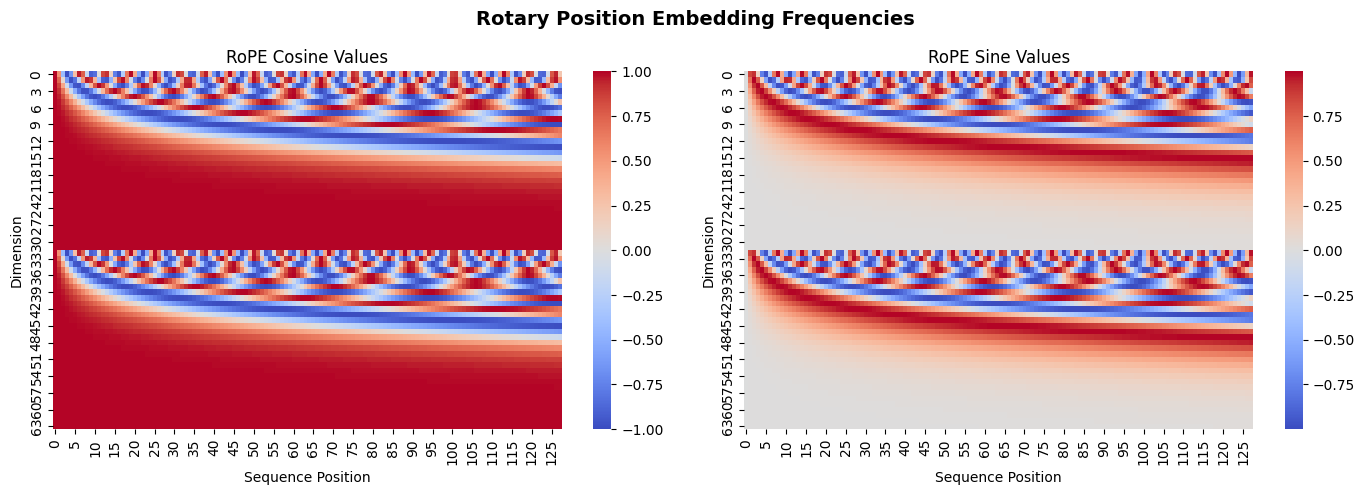

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class RotaryPositionalEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)"""
    def __init__(self, dim, max_seq_len=2048, base=10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base
        
        # Precompute frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        
        # Precompute positional encodings
        t = torch.arange(max_seq_len, dtype=torch.float32)
        freqs = torch.outer(t, inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos()[None, :, None, :])
        self.register_buffer("sin_cached", emb.sin()[None, :, None, :])
    
    def rotate_half(self, x):
        """Rotate half the hidden dims of the input."""
        x1, x2 = x.chunk(2, dim=-1)
        return torch.cat((-x2, x1), dim=-1)
    
    def apply_rotary_pos_emb(self, x, seq_len):
        """Apply rotary position embedding to input tensor."""
        cos = self.cos_cached[:, :seq_len, :, :]
        sin = self.sin_cached[:, :seq_len, :, :]
        return (x * cos) + (self.rotate_half(x) * sin)


class RoPEMLA(nn.Module):
    """Multi-Head Latent Attention with Rotary Position Embedding"""
    def __init__(self, d_model, n_heads, kv_latent_dim, max_seq_len=2048):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads
        self.kv_latent_dim = kv_latent_dim
        
        # Projection layers
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_dkv = nn.Linear(d_model, kv_latent_dim, bias=False)
        self.W_uk = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.W_uv = nn.Linear(kv_latent_dim, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        # Layer normalization for latent space
        self.ln = nn.LayerNorm(kv_latent_dim)
        
        # Rotary Position Embedding
        self.rope = RotaryPositionalEmbedding(self.dh, max_seq_len=max_seq_len)
        
        # Buffer for absorbed weights (computed on first forward pass)
        self.register_buffer("absorbed_k", None)
    
    def forward(self, x, kv_cache=None, past_length=0):
        B, S, D = x.size()
        
        # Compute absorbed weights on first forward pass
        if self.absorbed_k is None:
            absorbed = torch.matmul(self.W_q.weight, self.W_uk.weight)
            self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1)
        
        # Compute latent KV representations
        new_c_kv = self.ln(self.W_dkv(x))  # (B, S, kv_latent_dim)
        
        # Update KV cache
        if kv_cache is None:
            c_kv = new_c_kv
        else:
            c_kv = torch.cat([kv_cache, new_c_kv], dim=1)
        
        S_full = c_kv.size(1)  # Total sequence length
        
        # Compute queries
        q = self.W_q(x)  # (B, S, D)
        q = q.view(B, S, self.n_heads, self.dh)  # (B, S, n_heads, dh)
        
        # Apply RoPE to queries
        q = self.rope.apply_rotary_pos_emb(q, S)  # (B, S, n_heads, dh)
        
        # Compute keys from latent space
        k_full = self.W_uk(c_kv)  # (B, S_full, D)
        k = k_full.view(B, S_full, self.n_heads, self.dh)  # (B, S_full, n_heads, dh)
        
        # Apply RoPE to keys
        k = self.rope.apply_rotary_pos_emb(k, S_full)  # (B, S_full, n_heads, dh)
        
        # Compute values from latent space
        v_full = self.W_uv(c_kv)  # (B, S_full, D)
        v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1, 2)  # (B, n_heads, S_full, dh)
        
        # Rearrange q and k for attention computation
        q = q.transpose(1, 2)  # (B, n_heads, S, dh)
        k = k.transpose(1, 2)  # (B, n_heads, S_full, dh)
        
        # Compute attention scores: Q @ K^T
        attn_scores = torch.matmul(q, k.transpose(-2, -1))  # (B, n_heads, S, S_full)
        
        # Scale attention scores
        attn_scores = attn_scores / math.sqrt(self.dh)
        
        # Apply causal mask
        mask = torch.tril(torch.ones((S, S_full), device=x.device), diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))
        
        # Softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)  # (B, n_heads, S, S_full)
        
        # Apply attention to values
        context = torch.matmul(attn_weights, v)  # (B, n_heads, S, dh)
        
        # Concatenate heads
        context = context.transpose(1, 2).contiguous()  # (B, S, n_heads, dh)
        context = context.view(B, S, D)  # (B, S, D)
        
        # Output projection
        out = self.W_o(context)
        
        return out, c_kv


# === Demo: RoPE MLA ===
def demo_rope_mla():
    print("=== RoPE Multi-Head Latent Attention Demo ===\n")
    
    # Model parameters
    d_model = 512
    n_heads = 8
    kv_latent_dim = 256
    max_seq_len = 2048
    
    # Create model
    model = RoPEMLA(d_model=d_model, n_heads=n_heads, kv_latent_dim=kv_latent_dim, max_seq_len=max_seq_len)
    
    # Test 1: Initial forward pass
    print("Test 1: Initial forward pass")
    x = torch.randn(2, 10, d_model)  # (B=2, S=10, D=512)
    out, cache = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {out.shape}")
    print(f"Cache shape: {cache.shape}")
    print(f"Expected cache: (2, 10, {kv_latent_dim})\n")
    
    # Test 2: Incremental generation with cache
    print("Test 2: Incremental generation with cache")
    x_new = torch.randn(2, 1, d_model)  # (B=2, S=1, D=512)
    out_new, cache_new = model(x_new, kv_cache=cache, past_length=10)
    print(f"New input shape: {x_new.shape}")
    print(f"New output shape: {out_new.shape}")
    print(f"New cache shape: {cache_new.shape}")
    print(f"Expected cache: (2, 11, {kv_latent_dim})\n")
    
    # Test 3: Memory comparison
    print("Test 3: Memory comparison")
    B = 2
    S = 100
    
    # Standard KV cache: B * 2 (K,V) * S * d_model * float32 (4 bytes)
    std_size = B * 2 * S * d_model * 4 / 1024  # KB
    
    # Latent cache: B * S * kv_latent_dim * float32 (4 bytes)
    latent_size = B * S * kv_latent_dim * 4 / 1024  # KB
    
    print(f"Sequence length: {S}")
    print(f"Standard KV cache: {std_size:.1f} KB")
    print(f"Latent cache: {latent_size:.1f} KB")
    print(f"Memory reduction: {std_size/latent_size:.2f}x\n")
    
    # Test 4: Long sequence test
    print("Test 4: Long sequence test")
    x_long = torch.randn(1, 512, d_model)
    out_long, cache_long = model(x_long)
    print(f"Long input shape: {x_long.shape}")
    print(f"Long output shape: {out_long.shape}")
    print(f"Long cache shape: {cache_long.shape}")


# === Visualization: RoPE Frequencies ===
def visualize_rope_frequencies():
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("\n=== Visualizing RoPE Frequencies ===")
    
    rope = RotaryPositionalEmbedding(dim=64, max_seq_len=128)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot cosine cached values
    cos_data = rope.cos_cached[0, :, 0, :].cpu().numpy()
    sns.heatmap(cos_data.T, ax=axes[0], cmap="coolwarm", cbar=True)
    axes[0].set_title("RoPE Cosine Values")
    axes[0].set_xlabel("Sequence Position")
    axes[0].set_ylabel("Dimension")
    
    # Plot sine cached values
    sin_data = rope.sin_cached[0, :, 0, :].cpu().numpy()
    sns.heatmap(sin_data.T, ax=axes[1], cmap="coolwarm", cbar=True)
    axes[1].set_title("RoPE Sine Values")
    axes[1].set_xlabel("Sequence Position")
    axes[1].set_ylabel("Dimension")
    
    plt.suptitle("Rotary Position Embedding Frequencies", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    demo_rope_mla()
    visualize_rope_frequencies()